# Beggining

In [ ]:
import pandas as pd
import re
import requests
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import gaussian_kde, skew
import seaborn
from pickle import dump
from pickle import load
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn import metrics
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB

!pip install POT
import ot

seaborn.set()

In [ ]:
seasons = ['20'+str(i-1)+'-'+str(i) for i in range(13,20)]

def get_lle_space(X, n_components, n_neighbors):
  method = 'standard'

  lle_obj = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components, method = method)
  #lle_obj = KernelPCA(n_components=n_components, kernel='sigmoid')
  #lle_obj = PCA(n_components=n_components)
  lle_obj.fit(X)
  
  return lle_obj

def df_by_season(df, season):
  return df[df['season'] == season]

def get_players_ts(df):
  ts_columns = ['MIN','FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD']
  ts_num = 82
  
  plr_df = make_ts(df.sort_values(by=['PLAYER_ID', 'GAME_ID']), 
          id_column='PLAYER_ID', 
          columns_for_ts=ts_columns,
          columns_to_keep=['TEAM_ID', 'GAME_ID', 'WIN'], 
          num_of_shifts=ts_num,
          if_nan=0)

  return plr_df.sort_values(by=['GAME_ID'])

def colapse_ts(df):
  tmp_df = df.copy()

  for col in ts_columns:
    for i in range(ts_num, 1, -1):
      col_1 = str(i) + '-' + col
      col_2 = str(i-1) + '-' + col
      tmp_df[col_2] = df[col_2] - df[col_1]

  return tmp_df.drop(columns=['GAME_ID','TEAM_ID', 'WIN']).groupby(['PLAYER_ID']).sum().reset_index()

def get_colapsed(season):
  return df_by_season(all_season_ts, season).drop(columns=['season'])

def get_players_embeddings(lle_space, season, reduce_to=25, n_neighbors=20):
  '''
  #df = df_by_season(players, season)

  X = get_colapsed(season)#colapse_ts(get_players_ts(df))
  embeddings = pd.DataFrame(lle_space.transform(X.drop(columns=['PLAYER_ID'])))
  #embeddings = pd.DataFrame(lle_space.transform(X))
  
  return pd.concat([X['PLAYER_ID'].reset_index(drop=True), embeddings], axis=1)
  #df = df_by_season(players, season)
  #return df[['PLAYER_ID'] + ts_columns].groupby(['PLAYER_ID']).mean().reset_index()
  '''
  X = get_colapsed(season).reset_index(drop=True).drop(columns=['Unnamed: 0'])
  #print(X)
  player_embeddings = pd.concat([X['PLAYER_ID'], LLE(reduce_to, X.drop(columns=['PLAYER_ID']), n_neighbors=n_neighbors)], axis=1)
  return player_embeddings
  

def comparison_dataframe(df, drop=['PLAYER_ID']):
  mean_df = df.drop(columns=drop).groupby(['GAME_ID', 'TEAM_ID']).mean().reset_index()

  mean_df = mean_df.merge(mean_df, how='inner', on='GAME_ID').sort_values(by=['GAME_ID', 'TEAM_ID_x'])
  return mean_df.query('TEAM_ID_x != TEAM_ID_y') #.iloc[::2] 

def make_x_y(df):
  X = df.drop(columns=['WIN_x', 'WIN_y', 'GAME_ID', 'TEAM_ID_x', 'TEAM_ID_y', 'season'])
  y = df['WIN_x']
  
  return [X, y]


def make_collection(full_comp_df, r=range(0, 5), reduce=None, conseq=False):
  collection = []
  for i in r: #len(seasons)-1):
    arr = [seasons[i+2]]
    train_season = seasons[i+1]
    test_season = seasons[i+2]
    
    X_train, y_train = make_x_y(df_by_season(full_comp_df, train_season))
    X_test, y_test = make_x_y(df_by_season(full_comp_df, test_season))

    if conseq and collection:
      _, prev_X_train, prev_y_train, _, _ = collection[-1]
      X_train = pd.concat([prev_X_train, X_train])
      y_train = pd.concat([prev_y_train, y_train])
    
    if reduce is not None:
      red_obj = reduce(X_train)
      X_train = red_obj.transform(X_train)
      X_test = red_obj.transform(X_test)

    print(len(X_train), len(X_test))
    arr += [X_train, y_train]
    arr += [X_test, y_test]
    collection.append(tuple(arr))

  return collection

def max_accuracy(y_true, probs):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
  accuracy_scores = []
  for thresh in thresholds:
      accuracy_scores.append(metrics.accuracy_score(y_true, 
                                          [1 if m > thresh else 0 for m in probs]))

  accuracies = np.array(accuracy_scores)
  return accuracies.max() 

def max_tresh(y_true, probs):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, probs)
  accuracy_scores = []
  for thresh in thresholds:
      accuracy_scores.append((metrics.accuracy_score(y_true, 
                                          [1 if m > thresh else 0 for m in probs]), thresh))

  #accuracies = np.array(accuracy_scores)
  return max(accuracy_scores)[1] 

def plot_corr(df):
  f = plt.figure(figsize=(30, 30))
  plt.matshow(df.corr(), fignum=f.number)
  plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
  plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=14)
  plt.title('Correlation Matrix', fontsize=16);

def normalize_by(df, columns, by):
  for col in columns:
    df[col] /= df[by]

  return df

def remove_outliers(df, columns):
  ch_df = df[columns]
  return df[(np.abs(stats.zscore(ch_df)) < 3).all(axis=1)]


def plr_df_from_file(file_name):
  col_to_stat = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD']
  df = pd.read_csv(file_name)
  df.drop(columns=['Unnamed: 0'], inplace=True)

  # Clean DATA
  df.loc[df['MIN'] < 1, 'MIN'] = 1

  df['WIN'] = 1*(df['WL'] == 'W')

  #return df
  return normalize_by(df, ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD'], by='MIN')


df = plr_df_from_file('drive/My Drive/SL Project/player_games_with_inactive_score.csv')
players = plr_df_from_file('drive/My Drive/SL Project/players_with_inactive_score-2012-2019.csv')

# Kernel PCA

In [ ]:
def kernel_pca(n_comp, X, kernel='rbf'):
  kpca = KernelPCA(n_comp, kernel=kernel)
  X_kpca = kpca.fit_transform(X)

  kpca_df = pd.DataFrame(X_kpca)
  return kpca_df

def LLE(n_comp, X, method='standard', n_neighbors=5):
  if method == 'modified':
    n_neighbors = n_comp + 1
  elif method=='hessian':
    n_neighbors = int(n_comp * (n_comp + 3) / 2) + 2
  else:
    n_neighbors = n_neighbors

  embedding = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_comp, method = method)
  return pd.DataFrame(embedding.fit_transform(X))

def SE(n_comp, X):
  embedding = SpectralEmbedding(n_components=n_comp)
  return pd.DataFrame(embedding.fit_transform(X))

def pca(n_comp, X):
  pca = PCA(n_components=n_comp)
  return pd.DataFrame(pca.fit_transform(X))



# Blocked cross-validation

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# Feature importance

In [ ]:
import seaborn as sns
def plot_feature_importances(df_fi, num_limit = None):
    ''' Plot feature importances barplot'''
    if not num_limit:
        num_limit = df_fi.shape[0]
        
    f, ax = plt.subplots(figsize=(12, num_limit / 2))
    
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot( x="importance", y="feature", 
                data=df_fi[:num_limit], color="b"
               ).set_title('Feature importance')
    
    return df_fi

# Random Forest

In [ ]:
import threading
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

class ParaForest:
  seed = 0
  num_threads = 5
  
  def __init__(self, X=None, y=None, params=None, fit_instantly=True):
    self.params = params
    self.X = X
    self.y = y

    self.regressors = []
    self.forests  = []

    if fit_instantly:
      self.run_thread()

  def run_thread(self):
    threads = []
    for i in range(self.num_threads):
      threads.append( threading.Thread(target=self.__thread, args=(self.seed + i,)))
      threads[-1].start()

    for i in range(self.num_threads):
      threads[i].join()

    self.regressors[0].estimators_ = self.forests
    self.model = self.regressors[0]

  def __thread(self, seed):
    regr = RandomForestClassifier(**self.params, random_state=seed)
    regr.fit(self.X, self.y)
    self.regressors.append(regr)
    self.forests += regr.estimators_
    #print('Finished: ', seed)
    
  def fit(self, X, y):
    self.X = X
    self.y = y
    self.run_thread()
    return self

  def predict(self, x):
    return self.model.predict(x)
  


# Simple avarage features

In [ ]:
sa_ts_num = 60

def ts_for_avareging(sa_ts_num):
  ts_columns = ['MIN','FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD']

  plr_df = make_ts(players.sort_values(by=['PLAYER_ID', 'GAME_ID']), 
          id_column='PLAYER_ID', 
          columns_for_ts=ts_columns,
          columns_to_keep=['TEAM_ID', 'GAME_ID', 'WIN', 'season'], 
          num_of_shifts=sa_ts_num,
          if_nan=0)

  plr_back_ts = plr_df.dropna()
  return plr_back_ts

plr_back_ts = ts_for_avareging(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
def full_comp_for_avareging(plr_back_ts, ts_num, comparison=True):
  full_comp_df = plr_back_ts.loc[:, ['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'WIN']]
  season_df = plr_back_ts.loc[:, ['GAME_ID', 'season']].drop_duplicates()

  for col in ts_columns:
    full_comp_df.loc[:, col] = 0
    for i in range(1, ts_num+1):
      full_comp_df.loc[:, col] += plr_back_ts[str(i) + '-' + col] / ts_num

  if comparison:
    return comparison_dataframe(full_comp_df).merge(season_df, how='left', on='GAME_ID')
  return full_comp_df

full_comp_df = full_comp_for_avareging(plr_back_ts, 3, comparison=False)

## Make collection fuction

In [ ]:
seasons = ['20'+str(i-1)+'-'+str(i) for i in range(13,20)]

def make_collection(full_comp_df, r=range(0, 5), reduce=None, conseq=False):
  collection = []
  for i in r: #len(seasons)-1):
    arr = [seasons[i+2]]
    train_season = seasons[i+1]
    test_season = seasons[i+2]
    
    X_train, y_train = make_x_y(df_by_season(full_comp_df, train_season))
    X_test, y_test = make_x_y(df_by_season(full_comp_df, test_season))

    if conseq and collection:
      _, prev_X_train, prev_y_train, _, _ = collection[-1]
      X_train = pd.concat([prev_X_train, X_train])
      y_train = pd.concat([prev_y_train, y_train])
    
    if reduce is not None:
      red_obj = reduce(X_train)
      X_train = red_obj.transform(X_train)
      X_test = red_obj.transform(X_test)

    print(len(X_train), len(X_test))
    arr += [X_train, y_train]
    arr += [X_test, y_test]
    collection.append(tuple(arr))

  return collection
  

#collection = make_collection(full_comp_df)

## Optimal ts size

In [ ]:
res = []
for ts_size in [10,20, 30, 40, 50, 60, 70]:
  plr_back_ts = ts_for_avareging(ts_size)
  full_comp_df = full_comp_for_avareging(plr_back_ts, ts_size)
  
  collection = make_collection(full_comp_df, range(0,4))
  pf_res, cols, preds, av_accuracy = mul_train(collection)
  
  res.append((ts_size, av_accuracy))


res

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013-14 0.6036585365853658
2014-15 0.5804878048780487
2015-16 0.574390243902439
2016-17 0.5768292682926829
Avarage:  0.583841463414634


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013-14 0.6182926829268293
2014-15 0.6109756097560975
2015-16 0.5979674796747968
2016-17 0.5817073170731707
Avarage:  0.6022357723577235


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013-14 0.6308943089430894
2014-15 0.6207317073170732
2015-16 0.5857723577235773
2016-17 0.5991869918699188
Avarage:  0.6091463414634146


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013-14 0.6369918699186992
2014-15 0.6292682926829268
2015-16 0.5991869918699188
2016-17 0.6016260162601627
Avarage:  0.6167682926829268


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013-14 0.6447154471544716
2014-15 0.6292682926829268
2015-16 0.5910569105691057
2016-17 0.6085365853658536
Avarage:  0.6183943089430894


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013-14 0.6483739837398373
2014-15 0.6264227642276423
2015-16 0.5951219512195122
2016-17 0.6142276422764228
Avarage:  0.6210365853658537


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013-14 0.6455284552845528
2014-15 0.6235772357723577
2015-16 0.5898373983739837
2016-17 0.6231707317073171
Avarage:  0.6205284552845528


[(10, 0.583841463414634),
 (20, 0.6022357723577235),
 (30, 0.6091463414634146),
 (40, 0.6167682926829268),
 (50, 0.6183943089430894),
 (60, 0.6210365853658537),
 (70, 0.6205284552845528)]

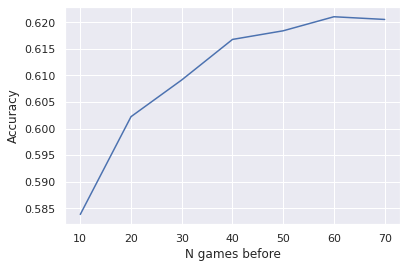

In [ ]:
res = [(10, 0.583841463414634),
 (20, 0.6022357723577235),
 (30, 0.6091463414634146),
 (40, 0.6167682926829268),
 (50, 0.6183943089430894),
 (60, 0.6210365853658537),
 (70, 0.6205284552845528)]
opt_size = np.array(res)
plt.plot(opt_size[:,0], opt_size[:,1])
plt.xlabel('N games before')
plt.ylabel('Accuracy')
plt.show()

# K-MEANS

In [ ]:
from sklearn.cluster import KMeans
sys_cols = ['GAME_ID', 'TEAM_ID', 'WIN', 'season', 'PLAYER_ID']
df_for_clust = df_by_season(plr_back_ts, '2013-14').drop(columns=sys_cols)
df_for_clust

,MIN_OK,1-MIN,2-MIN,3-MIN,FGM_OK,1-FGM,2-FGM,3-FGM,FGA_OK,1-FGA,2-FGA,3-FGA,FG_PCT_OK,1-FG_PCT,2-FG_PCT,3-FG_PCT,FG3M_OK,1-FG3M,2-FG3M,3-FG3M,FG3A_OK,1-FG3A,2-FG3A,3-FG3A,FG3_PCT_OK,1-FG3_PCT,2-FG3_PCT,3-FG3_PCT,OREB_OK,1-OREB,2-OREB,3-OREB,DREB_OK,1-DREB,2-DREB,3-DREB,AST_OK,1-AST,2-AST,3-AST,TOV_OK,1-TOV,2-TOV,3-TOV,STL_OK,1-STL,2-STL,3-STL,BLK_OK,1-BLK,2-BLK,3-BLK,BLKA_OK,1-BLKA,2-BLKA,3-BLKA,PF_OK,1-PF,2-PF,3-PF,PFD_OK,1-PFD,2-PFD,3-PFD
219,1,18.600000,27.580000,23.988333,1,0.376344,0.181291,0.250122,1,0.430108,0.398840,0.375182,1,0.875,0.455,0.667,1,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,1,0.000000,0.072516,0.000000,1,0.483871,0.217549,0.250122,1,0.161290,0.145033,0.125061,1,0.053763,0.108774,0.000000,1,0.053763,0.036258,0.083374,1,0.000000,0.000000,0.041687,1,0.0,0.0,0.0,1,0.053763,0.036258,0.000000,1,0.000000,0.072516,0.041687
220,1,26.280000,18.600000,27.580000,1,0.152207,0.376344,0.181291,1,0.304414,0.430108,0.398840,1,0.500,0.875,0.455,1,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,1,0.076104,0.000000,0.072516,1,0.304414,0.483871,0.217549,1,0.114155,0.161290,0.145033,1,0.076104,0.053763,0.108774,1,0.076104,0.053763,0.036258,1,0.038052,0.000000,0.000000,1,0.0,0.0,0.0,1,0.152207,0.053763,0.036258,1,0.000000,0.000000,0.072516
221,1,25.800000,26.280000,18.600000,1,0.116279,0.152207,0.376344,1,0.426357,0.304414,0.430108,1,0.273,0.500,0.875,1,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,1,0.038760,0.076104,0.000000,1,0.232558,0.304414,0.483871,1,0.077519,0.114155,0.161290,1,0.116279,0.076104,0.053763,1,0.038760,0.076104,0.053763,1,0.000000,0.038052,0.000000,1,0.0,0.0,0.0,1,0.116279,0.152207,0.053763,1,0.000000,0.000000,0.000000
222,1,22.416667,25.800000,26.280000,1,0.133829,0.116279,0.152207,1,0.490706,0.426357,0.304414,1,0.273,0.273,0.500,1,0.000000,0.000000,0.000000,1,0.044610,0.000000,0.000000,1,0.0,0.0,0.0,1,0.000000,0.038760,0.076104,1,0.223048,0.232558,0.304414,1,0.044610,0.077519,0.114155,1,0.044610,0.116279,0.076104,1,0.000000,0.038760,0.076104,1,0.044610,0.000000,0.038052,1,0.0,0.0,0.0,1,0.089219,0.116279,0.152207,1,0.178439,0.000000,0.000000
223,1,13.600000,22.416667,25.800000,1,0.147059,0.133829,0.116279,1,0.367647,0.490706,0.426357,1,0.400,0.273,0.273,1,0.000000,0.000000,0.000000,1,0.000000,0.044610,0.000000,1,0.0,0.0,0.0,1,0.000000,0.000000,0.038760,1,0.294118,0.223048,0.232558,1,0.073529,0.044610,0.077519,1,0.073529,0.044610,0.116279,1,0.000000,0.000000,0.038760,1,0.000000,0.044610,0.000000,1,0.0,0.0,0.0,1,0.073529,0.089219,0.116279,1,0.073529,0.178439,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141421,1,5.500000,7.166667,14.200000,1,0.181818,0.139535,0.000000,1,0.363636,0.279070,0.352113,1,0.500,0.500,0.000,1,0.000000,0.139535,0.000000,1,0.000000,0.139535,0.281690,1,0.0,1.0,0.0,1,0.000000,0.000000,0.000000,1,0.181818,0.000000,0.000000,1,0.000000,0.139535,0.000000,1,0.181818,0.000000,0.070423,1,0.363636,0.000000,0.070423,1,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,1,0.181818,0.000000,0.140845,1,0.181818,0.000000,0.000000
141422,1,11.416667,5.500000,7.166667,1,0.262774,0.181818,0.139535,1,0.350365,0.363636,0.279070,1,0.750,0.500,0.500,1,0.087591,0.000000,0.139535,1,0.175182,0.000000,0.139535,1,0.5,0.0,1.0,1,0.000000,0.000000,0.000000,1,0.000000,0.181818,0.000000,1,0.175182,0.000000,0.139535,1,0.000000,0.181818,0.000000,1,0.087591,0.363636,0.000000,1,0.000000,0.000000,0.000000,1,0.0,0.0,0.0,1,0.000000,0.181818,0.000000,1,0.175182,0.181818,0.000000
141423,1,13.683333,11.416667,5.500000,1,0.292326,0.262774,0.181818,1,0.438490,0.350365,0.363636,1,0.667,0.750,0.500,1,0.073082,0.087591,0.000000,1,0.146163,0.175182,0.000000,1,0.5,0.5,0.0,1,0.000000,0.000000,0.000000,1,0.073082,0.000000,0.181818,1,0.073082,0.175182,0.0

In [ ]:
for k in range(5,6):
  print(k)
  kmeanModel = KMeans(n_clusters=5)
  kmeanModel.fit(df_for_clust)
  kmeans_df = pd.concat([plr_back_ts[sys_cols], pd.DataFrame(kmeanModel.transform(plr_back_ts.drop(columns=sys_cols)))], axis=1)
  season_df = plr_back_ts[['GAME_ID', 'season']]
  full_comp_df = comparison_dataframe(kmeans_df).merge(season_df.drop_duplicates(), how='left', on='GAME_ID')
  collection = make_collection(full_comp_df)

# TS Features

In [ ]:
def ts_stat(ts_df, columns, stat_func):
  res_df = pd.DataFrame()
  for col in columns:
    res_df[col] = stat_func(ts_df[[str(i) + '-' + col for i in range(1, ts_num+1)]].values)
  return res_df

def slope(y):
  res = []
  x = list(range(len(y[0])))
  for i in range(len(y)):
    res.append(np.polyfit(x, y[i], 1)[0])
  
  return res

plr_ts = plr_back_ts.reset_index()

ts_stat_df = pd.concat([ plr_ts[['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'WIN']],
           ts_stat(plr_ts, ts_columns, lambda x: np.mean(x, axis=1)).add_prefix('mean-'),
           ts_stat(plr_ts, ts_columns, lambda x: np.median(x, axis=1)).add_prefix('median-'),
           ts_stat(plr_ts, ts_columns, lambda x: np.std(x, axis=1)).add_prefix('std-'),
           ts_stat(plr_ts, ts_columns, lambda x: np.min(x, axis=1)).add_prefix('min-'),
           ts_stat(plr_ts, ts_columns, lambda x: np.max(x, axis=1)).add_prefix('max-'),
           ts_stat(plr_ts, ts_columns, lambda x: skew(x, axis=1)).add_prefix('skew-'),

           ts_stat(plr_ts, ts_columns, lambda x: slope(x)).add_prefix('slope-')], axis=1)

ts_stat_df.head(5)

,GAME_ID,TEAM_ID,PLAYER_ID,WIN,mean-MIN,mean-FGM,mean-FGA,mean-FG_PCT,mean-FG3M,mean-FG3A,mean-FG3_PCT,mean-OREB,mean-DREB,mean-AST,mean-TOV,mean-STL,mean-BLK,mean-BLKA,mean-PF,mean-PFD,median-MIN,median-FGM,median-FGA,median-FG_PCT,median-FG3M,median-FG3A,median-FG3_PCT,median-OREB,median-DREB,median-AST,median-TOV,median-STL,median-BLK,median-BLKA,median-PF,median-PFD,std-MIN,std-FGM,std-FGA,std-FG_PCT,...,max-DREB,max-AST,max-TOV,max-STL,max-BLK,max-BLKA,max-PF,max-PFD,skew-MIN,skew-FGM,skew-FGA,skew-FG_PCT,skew-FG3M,skew-FG3A,skew-FG3_PCT,skew-OREB,skew-DREB,skew-AST,skew-TOV,skew-STL,skew-BLK,skew-BLKA,skew-PF,skew-PFD,slope-MIN,slope-FGM,slope-FGA,slope-FG_PCT,slope-FG3M,slope-FG3A,slope-FG3_PCT,slope-OREB,slope-DREB,slope-AST,slope-TOV,slope-STL,slope-BLK,slope-BLKA,slope-PF,slope-PFD
0,21200541,1610612746,255,0,0.000000,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,21200559,1610612746,255,1,0.320833,0.000000,0.023377,0.000,0.0,0.0,0.0,0.000000,0.015584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.398480,0.000000,0.101896,0.000000,...,0.311688,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.155844,4.129483,0.000000,4.129483,0.000000,0.0,0.0,0.0,0.000000,4.129483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.129483,-0.091667,0.000000,-0.006679,0.000000,0.0,0.0,0.0,0.000000,-0.004453,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002226
2,21200567,1610612746,255,1,1.180833,0.008721,0.037912,0.030,0.0,0.0,0.0,0.002907,0.024305,0.011628,0.002907,0.000000,0.002907,0.000000,0.005814,0.010699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.931452,0.038014,0.117121,0.130767,...,0.311688,0.232558,0.058140,0.000000,0.05814,0.000000,0.116279,0.155844,3.476165,4.129483,2.940071,4.129483,0.0,0.0,0.0,4.129483,3.049894,4.129483,4.129483,0.000000,4.129483,0.000000,4.129483,3.476165,-0.327732,-0.002492,-0.010129,-0.008571,0.0,0.0,0.0,-0.000831,-0.006476,-0.003322,-0.000831,0.000000,-0.000831,0.000000,-0.001661,-0.002823
3,21200581,1610612746,255,1,2.000000,0.011773,0.044015,0.055,0.0,0.0,0.0,0.002907,0.024305,0.017732,0.009011,0.003052,0.002907,0.003052,0.021073,0.019855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.125560,0.039608,0.118162,0.165756,...,0.311688,0.232558,0.122075,0.061038,0.05814,0.061038,0.305188,0.183113,2.390394,3.534829,2.727623,2.711872,0.0,0.0,0.0,4.129483,3.049894,3.119290,3.225547,4.129483,4.129483,4.129483,3.456091,2.466495,-0.526266,-0.003101,-0.010733,-0.014812,0.0,0.0,0.0,-0.000743,-0.005745,-0.004716,-0.002487,-0.000872,-0.000743,-0.000872,-0.005846,-0.005117
4,21200600,1610612746,255,1,2.925833,0.011773,0.046716,0.055,0.0,0.0,0.0,0.002907,0.027006,0.020432,0.009011,0.003052,0.002907,0.003052,0.026474,0.019855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.233314,0.039608,0.117742,0.165756,...,0.311688,0.232558,0.122075,0.061038,0.05814,0.061038,0.305188,0.183113,1.812028,3.534829,2.690772,2.711872,0.0,0.0,0.0,4.129483,2.942291,2.927578,3.225547,4.129483,4.129483,4.129483,3.000361,2.466495,-0.730639,-0.002747,-0.010180,-0.013158,0.0,0.0,0.0,-0.000656,-0.005785,-0.004955,-0.002216,-0.000780,-0.000656,-0.000780,-0.006755,-0.004520


In [ ]:
df_to_compare = ts_stat_df
season_df = plr_ts[['GAME_ID', 'season']]
full_comp_df = comparison_dataframe(df_to_compare).merge(season_df.drop_duplicates(), how='left', on='GAME_ID').sort_values(['GAME_ID', 'TEAM_ID_x'])
full_comp_df

,GAME_ID,TEAM_ID_x,WIN_x,mean-MIN_x,mean-FGM_x,mean-FGA_x,mean-FG_PCT_x,mean-FG3M_x,mean-FG3A_x,mean-FG3_PCT_x,mean-OREB_x,mean-DREB_x,mean-AST_x,mean-TOV_x,mean-STL_x,mean-BLK_x,mean-BLKA_x,mean-PF_x,mean-PFD_x,median-MIN_x,median-FGM_x,median-FGA_x,median-FG_PCT_x,median-FG3M_x,median-FG3A_x,median-FG3_PCT_x,median-OREB_x,median-DREB_x,median-AST_x,median-TOV_x,median-STL_x,median-BLK_x,median-BLKA_x,median-PF_x,median-PFD_x,std-MIN_x,std-FGM_x,std-FGA_x,std-FG_PCT_x,std-FG3M_x,...,max-AST_y,max-TOV_y,max-STL_y,max-BLK_y,max-BLKA_y,max-PF_y,max-PFD_y,skew-MIN_y,skew-FGM_y,skew-FGA_y,skew-FG_PCT_y,skew-FG3M_y,skew-FG3A_y,skew-FG3_PCT_y,skew-OREB_y,skew-DREB_y,skew-AST_y,skew-TOV_y,skew-STL_y,skew-BLK_y,skew-BLKA_y,skew-PF_y,skew-PFD_y,slope-MIN_y,slope-FGM_y,slope-FGA_y,slope-FG_PCT_y,slope-FG3M_y,slope-FG3A_y,slope-FG3_PCT_y,slope-OREB_y,slope-DREB_y,slope-AST_y,slope-TOV_y,slope-STL_y,slope-BLK_y,slope-BLKA_y,slope-PF_y,slope-PFD_y,season
0,21200001,1610612739,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012-13
1,21200001,1610612764,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012-13
2,21200002,1610612738,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012-13
3,21200002,1610612748,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012-13
4,21200003,1610612742,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

# LLE Features


In [ ]:
ts_columns = ['MIN','FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD']
ts_num = 40

plr_df = make_ts(players.sort_values(by=['PLAYER_ID', 'GAME_ID']), 
        id_column='PLAYER_ID', 
        columns_for_ts=ts_columns,
        columns_to_keep=['TEAM_ID', 'GAME_ID', 'WIN', 'season'], 
        num_of_shifts=ts_num,
        if_nan=np.nan)

plr_40_ts = plr_df.dropna()
plr_40_ts

In [ ]:
seasons = ['20'+str(i-1)+'-'+str(i) for i in range(13,20)]
all_season_ts = pd.DataFrame()

for s in seasons:
  X = colapse_ts(get_players_ts(df_by_season(players, s)))
  X['season'] = s
  all_season_ts = pd.concat([all_season_ts, X])

all_season_ts.to_csv('drive/My Drive/SL Project/all_seasons_players_ts.csv')
all_season_ts

In [ ]:
seasons = ['20'+str(i-1)+'-'+str(i) for i in range(13,20)]

reduce_to = 25
n_neighbors = 20

lle_train_df = pd.concat([
                  get_colapsed(seasons[0]).drop(columns=['PLAYER_ID'])]) #,
                  #get_colapsed(seasons[0])])
                  #get_colapsed(seasons[1]).drop(columns=['PLAYER_ID'])])
                  #colapse_ts(get_players_ts(df_by_season(players, seasons[0]))),
                  #colapse_ts(get_players_ts(df_by_season(players, seasons[1])))])
                  #colapse_ts(get_players_ts(df_by_season(players, seasons[0]))).drop(columns=['PLAYER_ID']),
                  #colapse_ts(get_players_ts(df_by_season(players, seasons[1]))).drop(columns=['PLAYER_ID'])])

#lle_train_df = df_by_season(plr_40_ts, seasons[0]).drop(columns=['TEAM_ID', 'GAME_ID', 'WIN', 'season', 'PLAYER_ID'])

lle_space = get_lle_space(lle_train_df, reduce_to, n_neighbors)



collection = []

full_comp_df = pd.DataFrame()

for i in range(0, 5): #len(seasons)-1):
  print(i)
  season_for_embeddings = seasons[i+1]
  season_for_training = seasons[i+1]
  test_season = seasons[i+2]
  
  
  player_embeddings = get_players_embeddings(lle_space, season_for_embeddings, reduce_to, n_neighbors)

  #print(player_embeddings)

  arr = [seasons[i+2]]
  for s in [season_for_training, test_season]:
    tmp_df = df_by_season(players, s)[['PLAYER_ID', 'GAME_ID', 'TEAM_ID', 'WIN', 
                                       #'inactive_score'
                                       ]].merge(
        player_embeddings, how='left', on='PLAYER_ID')
    
    tmp_df = comparison_dataframe(tmp_df)
    tmp_df['season'] = s

    # merge Lev's features
    tmp_df = tmp_df.merge(lev_df, how='left', on=['GAME_ID', 'TEAM_ID_x', 'TEAM_ID_y'])
    tmp_df = tmp_df.merge(games_df, how='left', on=['GAME_ID', 'TEAM_ID_x'])
    tmp_df = tmp_df.merge(comparison_dataframe(players[['GAME_ID', 'TEAM_ID' , 'inactive_score', 'PLAYER_ID']]),
                   how='left', on=['GAME_ID', 'TEAM_ID_x']).sort_values(['GAME_ID', 'TEAM_ID_x'])
    
    arr += make_x_y(tmp_df)

  collection.append(tuple(arr))

#full_comp_df
collection

# Concat all features

In [ ]:
lev_df = pd.read_csv('drive/My Drive/SL Project/LEV_2012_2019_features.csv').drop(columns=['SEASON', 'GAME_DATE', 'LABLE', 'Unnamed: 0'])

In [ ]:
# Game features
games_df = pd.read_csv('drive/My Drive/SL Project/games_with_staff_changes_score.csv', engine='python')
games_df = games_df[['GAME_ID', 'TEAM_ID', 'num_loose_before', 'num_win_before', 'prev_matchup_win', 'prev_matchup_loose', 'staff_changes_score']]
games_df['played_games'] = games_df['num_loose_before'] + games_df['num_win_before']

for col in ['num_loose_before', 'num_win_before']:
  #games_df[col] = (games_df[col] + 1) / (games_df['played_games'] + 1)
  games_df[col] = (games_df[col]) / (games_df['played_games'])
  games_df[col] = games_df[col].replace(np.nan, 0)

games_df['part_of_season'] = 0
games_df['part_of_season'] += 1*(games_df['played_games'] < 2)
games_df['part_of_season'] += 2*((games_df['played_games'] >= 2) & (games_df['played_games'] <= 70))
#games_df = games_df.merge(games_ts_df[['GAME_ID', 'TEAM_ID', 'win_hist_type']], how='left', on=['GAME_ID', 'TEAM_ID'])
games_df.drop(columns=['played_games'], inplace=True)


games_df = games_df.merge(games_df, how='inner', on='GAME_ID').sort_values(by=['GAME_ID'])
games_df = games_df.query('TEAM_ID_x != TEAM_ID_y')
games_df.head()


In [ ]:
full_comp_df = full_comp_df.merge(lev_df, how='left', on=['GAME_ID', 'TEAM_ID_x', 'TEAM_ID_y']).sort_values(['GAME_ID', 'TEAM_ID_x'])
full_comp_df = full_comp_df.merge(games_df, how='left', on=['GAME_ID', 'TEAM_ID_x']).sort_values(['GAME_ID', 'TEAM_ID_x'])
full_comp_df = full_comp_df.merge(comparison_dataframe(players[['GAME_ID', 'TEAM_ID' , 'inactive_score', 'PLAYER_ID']]),
                   how='left', on=['GAME_ID', 'TEAM_ID_x']).sort_values(['GAME_ID', 'TEAM_ID_x'])

full_comp_df = full_comp_df.dropna()

collection = make_collection(full_comp_df)

# Training by seasons 

In [ ]:
def mul_train(data, model_func, roc_auc=False, keep_only=None, conseq=False, no_train=False):
  res = []
  preds = []
  train_accuracy, accuracy = 0, 0
  prev_X_train, prev_y_train = None, None
  stat = [] 

  for label, X_train, y_train, X_test, y_test in data:
    if keep_only is not None:
      X_train = X_train[keep_only]
      X_test = X_test[keep_only]
    
    if conseq and prev_X_train is not None:
      X_train = pd.concat([prev_X_train, X_train])
      y_train = pd.concat([prev_y_train, y_train])

    model = model_func(X_train, y_train)
    y_pred = model.predict(X_test)

    if not no_train:
      y_train_pred = model.predict(X_train)

    prev_X_train, prev_y_train = X_train, y_train
    
    if roc_auc:
      #acc = metrics.roc_auc_score(y_test, y_pred)
      acc = max_accuracy(y_test, y_pred)
      if not no_train:
        train_acc = max_accuracy(y_train, y_train_pred)
    else:
      acc = np.mean(y_pred == y_test.values)
      if not no_train:
        train_acc = np.mean(y_train_pred == y_train.values)
    
    accuracy += acc / len(data)
    
    if not no_train:
      train_accuracy += train_acc / len(data)
    else:
      train_accuracy = 0
      train_acc = 0

    stat.append([label, train_acc, acc])
    print('{} train = {}, test = {}'.format(label, train_acc, acc))
    res.append(model)
    preds.append((y_pred, y_test))

  print('Avarage accuracy: train = {}, test = {}'.format(train_accuracy, accuracy))
  stat.append(['Total', train_accuracy, accuracy])
  stat = pd.DataFrame(stat, columns=['season', 'train', 'test'])

  return res, X_train.columns, preds, accuracy, stat

def forest_func(X_train, y_train):
  return ParaForest(X_train, y_train, {'n_estimators': 300, 'oob_score': True , 'n_jobs': 4, 'max_depth' : 4})

def linear_svm_func(X_train, y_train):
  cls = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=2000, C=0.0001))
  #cls = make_pipeline(StandardScaler(), NuSVC(nu=0.9))
  return cls.fit(X_train, y_train)

def svm_func(X_train, y_train):
  cls = make_pipeline(StandardScaler(), SVC(random_state=0,  C=1))
  #cls = make_pipeline(StandardScaler(), NuSVC(nu=0.9))
  return cls.fit(X_train, y_train)

def lr_func(X_train, y_train):
  return Ridge(random_state=1, alpha=1, normalize=True).fit(X_train, y_train)
  #return Lasso(random_state=1, alpha=0.0001, max_iter=10000, normalize=True).fit(X_train, y_train)
  
def logistic_func(X_train, y_train):
  #penalty='elasticnet', 'l1'
  X = normalize(X_train)
  return LogisticRegression(random_state=0, penalty='l2', C=100).fit(X_train, y_train)

def tree_func(X_train, y_train):
  return DecisionTreeClassifier(criterion="entropy", max_depth=3).fit(X_train, y_train)

def lda_func(X_train, y_train):
  return LinearDiscriminantAnalysis(solver='svd',  tol=0.001).fit(X_train, y_train)

conseq = False
#keep_only = None
#models, cols, preds, av_accuracy, stat_df = mul_train(collection, svm_func, conseq=conseq, keep_only=keep_only)
#models, cols, preds, av_accuracy, stat_df = mul_train(collection, lr_func, True, conseq=conseq, keep_only=keep_only, no_train=True)
models, cols, preds, av_accuracy, stat_df = mul_train(collection, forest_func, conseq=conseq, keep_only=keep_only)
#models, cols, preds, av_accuracy, stat_df = mul_train(collection, logistic_func, True, conseq=conseq)
#models, cols, preds, av_accuracy, stat_df = mul_train(collection, tree_func, conseq=conseq)#, keep_only=keep_only)
#models, cols, preds, av_accuracy, stat_df = mul_train(collection, lda_func, conseq=conseq)#, keep_only=keep_only)

In [ ]:
to_dump = {
    'preds': preds, 
    'cols': cols,
    'stat': stat_df.values
}
dump(to_dump, open('drive/My Drive/SL Project/output/[C]kmeans_forest.pkl', 'wb'))

In [ ]:
pf_res = models
d = defaultdict(float)
for i in range(len(pf_res)):
  for key, val in dict(zip(cols, list(pf_res[i].model.feature_importances_))).items():
    d[key] += val/len(pf_res)

import_df = pd.DataFrame(d.items(), columns=['feature', 'importance']).sort_values(by=['importance'], ascending=False).reset_index(drop=True)
plot_feature_importances(import_df)

### Importance

,feature,importance
0,num_win_before_x,0.116363
1,num_win_before_y,0.114312
2,Dist_away,0.045025
3,FG_PCT_x,0.040612
4,FG_PCT_y,0.039769
5,FGM_x,0.039209
6,FGM_y,0.038983
7,AST_y,0.036104
8,AST_x,0.035562
9,HOME_LABLE,0.033842


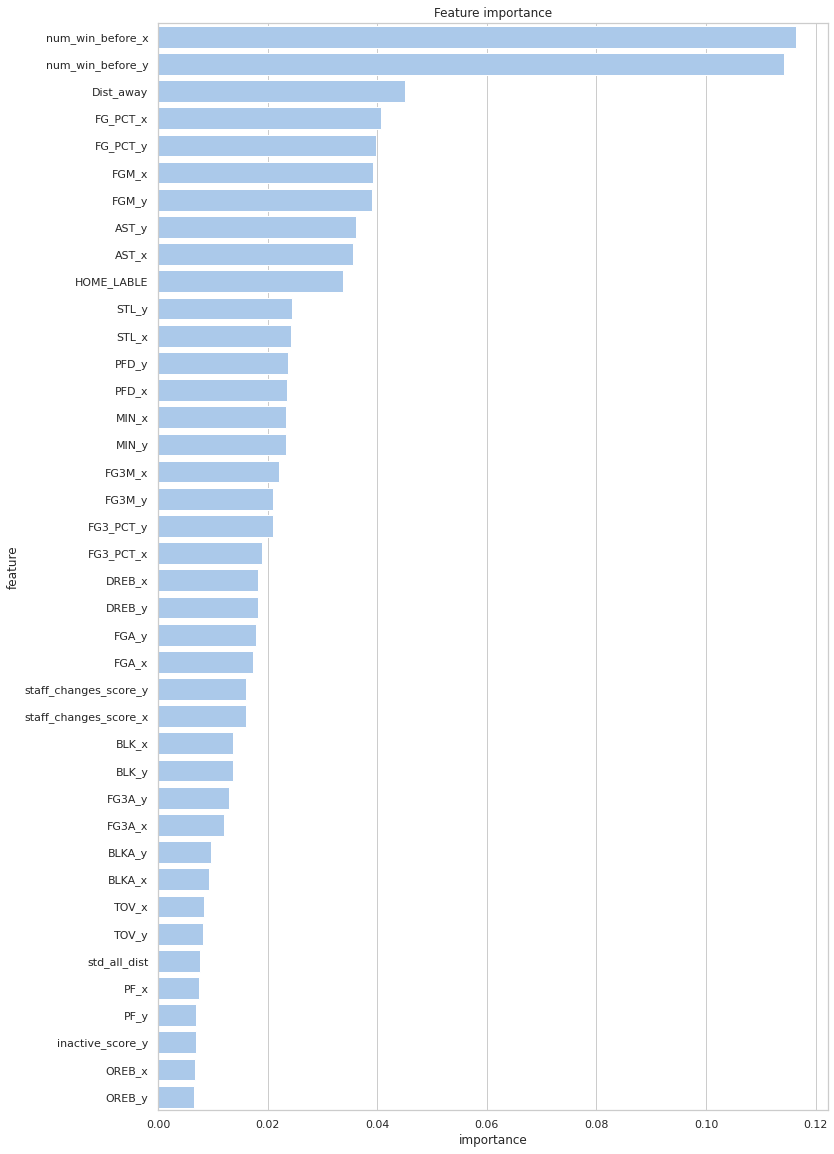

In [ ]:
pf_res = models
d = defaultdict(float)
for i in range(len(pf_res)):
  for key, val in dict(zip(cols, list(pf_res[i].model.feature_importances_))).items():
    d[key] += val/len(pf_res)

import_df = pd.DataFrame(d.items(), columns=['feature', 'importance']).sort_values(by=['importance'], ascending=False).reset_index(drop=True)
plot_feature_importances(import_df)

# TRAINIGN BY SEASON 2

In [ ]:
def convert_by_max_tresh(y_true, probs):
  tresh = max_tresh(y_true, probs)
  return (probs > tresh)*1


def cross_validation(model, X_train, y_train, X_test, cv_type, test_from_future=False):
  n_splits = 20

  if cv_type == 1:
    kfold = TimeSeriesSplit(n_splits=n_splits)
  elif cv_type==2:
    kfold = BlockingTimeSeriesSplit(n_splits=n_splits)
  else:
    kfold = KFold(n_splits = n_splits, shuffle = True, random_state = 50)

  inputs_arr = np.array(X_train)
  outputs_arr = np.array(y_train).reshape(-1,)
  x_test = np.array(X_test)
  if test_from_future:
    all_y_tests = np.array([])
    y_pred = np.array([])
  else:
    y_pred = np.zeros(x_test.shape[0])
  
  num_to_test = int(len(inputs_arr) / kfold.n_splits)
  pred_results = []
  total_accuracy = 0
  valid_accuracy = 0
  total_test_size = 0
  stopped = False

  for train_samp, valid_samp in kfold.split(inputs_arr, outputs_arr):
    model.fit(inputs_arr[train_samp, :], outputs_arr[train_samp,])
    
    if test_from_future:
      if valid_samp[-1] + num_to_test <= len(inputs_arr):
        test_indecies = np.array(range(valid_samp[-1], valid_samp[-1] + num_to_test))
      else:
        break
       
      x_test = inputs_arr[test_indecies, :]
      y_test = outputs_arr[test_indecies,]
      all_y_tests = np.append(all_y_tests, y_test)

      part_pred = model.predict(x_test)
      y_pred = np.append(y_pred, convert_by_max_tresh(y_test, part_pred))

      pred_results.append((y_test, part_pred))
      acc = max_accuracy(y_test, part_pred)
      total_test_size += len(part_pred)
      total_accuracy += acc
      valid_accuracy = max_accuracy(outputs_arr[valid_samp,], model.predict(inputs_arr[valid_samp, :]))
    else:
      print('Valid score: ', max_accuracy(outputs_arr[valid_samp,], model.predict(inputs_arr[valid_samp, :])))
      y_pred += model.predict(x_test) / kfold.n_splits
  
  #print(total_accuracy /(len(pred_results)+1))
  total_accuracy = total_accuracy/len(pred_results)
  print('Valid accuracy: {}, Test accuracy: {}, test size: {}'.format(valid_accuracy, total_accuracy, total_test_size))
  return y_pred, all_y_tests, total_accuracy

def cross_mul_train(data, model_func, roc_auc=False, keep_only=None, conseq=False, no_train=False, test_from_future=False, cv_type=1):
  res = []
  preds = []
  train_accuracy, accuracy = 0, 0
  prev_X_train, prev_y_train = None, None
  stat = [] 
  cols = []

  for label, X_train, y_train, X_test, y_test in data:
    if keep_only is not None:
      X_train = X_train[keep_only]
      X_test = X_test[keep_only]
    
    if conseq and prev_X_train is not None:
      X_train = pd.concat([prev_X_train, X_train])
      y_train = pd.concat([prev_y_train, y_train])

    model = model_func()
    
    
    if test_from_future:
      print(label)
      y_pred, y_test, acc = cross_validation(model, X_test, y_test, X_test, cv_type, test_from_future=test_from_future)
      accuracy += acc / len(data)
      
      print('==== >Check accuracy: ', max_accuracy(y_test, y_pred))
      stat.append([label, 0, acc])
    else:
      y_pred, _ = cross_validation(model, X_train, y_train, X_test, cv_type, test_from_future=test_from_future)

      if not no_train:
        y_train_pred = model.predict(X_train)

      prev_X_train, prev_y_train = X_train, y_train
      
      if roc_auc:
        #acc = metrics.roc_auc_score(y_test, y_pred)
        acc = max_accuracy(y_test, y_pred)
        if not no_train:
          train_acc = max_accuracy(y_train, y_train_pred)
      else:
        acc = np.mean(y_pred == y_test.values)
        if not no_train:
          train_acc = np.mean(y_train_pred == y_train.values)
      
      accuracy += acc / len(data)
      
      if not no_train:
        train_accuracy += train_acc / len(data)
      else:
        train_accuracy = 0
        train_acc = 0

      stat.append([label, train_acc, acc])
      print('{} train = {}, test = {}'.format(label, train_acc, acc))
      res.append(model)
      cols = X_train.columns
      
    # Used to store
    preds.append((y_pred, y_test))

  print('Avarage accuracy: train = {}, test = {}'.format(train_accuracy, accuracy))
  stat.append(['Total', train_accuracy, accuracy])
  stat = pd.DataFrame(stat, columns=['season', 'train', 'test'])

  return res, cols, preds, accuracy, stat

def forest_func():
  params = {'n_estimators': 800, 'oob_score': True , 'n_jobs': 4, 'max_depth' : 4}
  return RandomForestClassifier(**params, random_state=0)
  #return ParaForest(params={'n_estimators': 400, 'oob_score': True , 'n_jobs': 4, 'max_depth' : 4}, fit_instantly=False)
  #return ParaForest(X_train, y_train, {'n_estimators': 400, 'oob_score': True , 'n_jobs': 4, 'max_depth' : 3})

def linear_svm_func():
  cls = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=2000, C=0.01))
  #cls = make_pipeline(StandardScaler(), NuSVC(nu=0.9))
  return cls

def svm_func():
  cls = make_pipeline(StandardScaler(), SVC(random_state=0, kernel="rbf", C=5))
  #cls = make_pipeline(StandardScaler(), NuSVC(nu=0.9))
  return cls

def lr_func():
  return Ridge(random_state=0, alpha=2, normalize=True)
  #return Lasso(random_state=1, alpha=0.0001, max_iter=10000, normalize=True)
  
def logistic_func():
  return make_pipeline(StandardScaler(), LogisticRegression(random_state=0, penalty='l2', C=0.01))

def tree_func():
  return DecisionTreeClassifier(criterion="entropy", max_depth=6)

def lda_func():
  return LinearDiscriminantAnalysis(solver='svd',  tol=0.001)

def qda_func():
  return QuadraticDiscriminantAnalysis(reg_param=0.001)

def naive_func():
  return BernoulliNB()


cv_type = 1
conseq = False 
#keep_only = None
#_,_, preds,_,stat = cross_mul_train(collection, linear_svm_func, True, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)#
#_,_, preds,_,stat = cross_mul_train(collection, lr_func, True, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)#
#_,_, preds,_,stat = cross_mul_train(collection, forest_func, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)
#_,_, preds,_,stat = cross_mul_train(collection, logistic_func, True, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)
#_,_, preds,_,stat = cross_mul_train(collection, tree_func, True, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)
#_,_, preds,_,stat = cross_mul_train(collection, lda_func, True, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)
#_,_, preds,_,stat = cross_mul_train(collection, qda_func, True, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)
#_,_, preds,_,stat = cross_mul_train(collection, naive_func, True, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)

In [ ]:
cv_type = 1
dataset_name = 'kmeans_'
for func in [naive_func, qda_func, lda_func, svm_func, lr_func, linear_svm_func, logistic_func, tree_func, forest_func]:
  file_name = dataset_name + func.__name__
  print()
  print(file_name)
  _,cols, preds,_,stat = cross_mul_train(collection, func, True, conseq=conseq, keep_only=keep_only, no_train=True, test_from_future=True, cv_type=cv_type)
  to_dump = {
    'preds': preds, 
    'cols': cols,
    'stat': stat.values
    }
  break
stat.values
  #dump(to_dump, open('drive/My Drive/SL Project/output_3/{}.csv'.format(file_name), 'wb'))


kmeans_naive_func
2014-15
Valid accuracy: 0.5213675213675214, Test accuracy: 0.571364046973803, test size: 2214
==== >Check accuracy:  0.571364046973803
2015-16
Valid accuracy: 0.6752136752136753, Test accuracy: 0.5849141824751581, test size: 2214
==== >Check accuracy:  0.5849141824751581
2016-17
Valid accuracy: 0.5555555555555556, Test accuracy: 0.580397470641373, test size: 2214
==== >Check accuracy:  0.580397470641373
2017-18
Valid accuracy: 0.5555555555555556, Test accuracy: 0.5840108401084012, test size: 2214
==== >Check accuracy:  0.5840108401084011
2018-19
Valid accuracy: 0.5384615384615384, Test accuracy: 0.5930442637759712, test size: 2214
==== >Check accuracy:  0.5930442637759711
Avarage accuracy: train = 0, test = 0.5827461607949413


array([['2014-15', 0, 0.11427280939476062],
       ['2015-16', 0, 0.23125564588979225],
       ['2016-17', 0, 0.34733514001806687],
       ['2017-18', 0, 0.4641373080397471],
       ['2018-19', 0, 0.5827461607949413],
       ['Total', 0, 0.5827461607949413]], dtype=object)

## Major voting

In [ ]:
def make_preds_df(groups, treshold=0.5):
  num_groups = len(groups)
  preds_matrix, y_list = [], []
  for i in range(len(groups[0])):
    #preds_matrix += list(zip( *[groups[k][i][0] for k in range(num_groups)] ))
    #preds_matrix += list(sum([groups[k][i][0] for k in range(num_groups)] ))
    preds_matrix += list(zip( *[groups[k][i][0] for k in range(num_groups)] ))
    y_list += list(zip( *[groups[k][i][1] for k in range(num_groups)] ))

  majority = num_groups * treshold
  res = 1*(np.array(preds_matrix) >= majority)
  return preds_matrix, pd.DataFrame(y_list), res

def check_y_df(y_df):
  for i in range(len(y_df.columns)-1):
    if sum(y_df[i] != y_df[i+1]) != 0:
      return 'Error in labels'

In [ ]:
from os import listdir
from os.path import isfile, join
mypath = 'drive/My Drive/SL Project/output_3/'
groups = []
columns=[]
for file_name in [f for f in listdir(mypath) if isfile(join(mypath, f))]:
  if '[Blocked]' not in file_name:
    columns.append(file_name)
    obj = load(open(mypath + file_name, 'rb'))
    groups.append(obj['preds'])

m, y_df, p_mat = make_preds_df(groups, 0.44)
check_y_df(y_df)
#print( np.mean(p_mat == y_df[0]))
m = pd.DataFrame(m, columns=columns)
m

,ave_naive_func.csv,ave_qda_func.csv,ave_lda_func.csv,ave_svm_func.csv,ave_lr_func.csv,ave_linear_svm_func.csv,ave_logistic_func.csv,ave_tree_func.csv,ave_forest_func.csv,ts_naive_func.csv,ts_qda_func.csv,ts_lda_func.csv,ts_svm_func.csv,ts_lr_func.csv,ts_linear_svm_func.csv,ts_logistic_func.csv,ts_tree_func.csv,ts_forest_func.csv,kmeans_lr_func.csv,kmeans_linear_svm_func.csv,kmeans_logistic_func.csv,kmeans_tree_func.csv,kmeans_forest_func.csv,lle_naive_func.csv,lle_qda_func.csv,lle_lda_func.csv,lle_svm_func.csv,lle_lr_func.csv,lle_linear_svm_func.csv,lle_logistic_func.csv,lle_tree_func.csv,lle_forest_func.csv,kmeans_naive_func.csv,kmeans_qda_func.csv,kmeans_lda_func.csv,kmeans_svm_func.csv
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
11066,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11068,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#k_choice = [13, 22, 31]
k_choice = ['ave_lr_func.csv', 'ts_lr_func.csv', 'kmeans_lr_func.csv'] 
#k_choice = list(range(36))

In [ ]:
'''
m_cp = m.copy()
#tresh = 0.5
#for k in [1, 2, 12, 13, 16, 17, 24, 25]:
for k in [1, 5, 11, 16]:
  tresh = max_tresh(y_df[0], m_cp[k])
  m_cp[k] = 1*(m_cp[k] > tresh)

m_cp.to_csv('drive/My Drive/SL Project/major_vote_2.csv')


'''
#m_cp = pd.read_csv('drive/My Drive/SL Project/major_vote.csv').drop(columns=['Unnamed: 0'])

#m_cp = m_cp[map(lambda x: str(x), [1, 10, 12, 13, 22, 16, 17, 18, 19])] #.drop(columns=removed)
m_cp = m[k_choice]
for k in range(1, len(m_cp.columns)):
  m_cp[m_cp.columns[0]] += m_cp[m_cp.columns[k]]

t2 = len(m_cp.columns) * 0.5
np.mean(1*(m_cp[m_cp.columns[0]] > t2)  == y_df[0])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.6907859078590786